In [1]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from keras.preprocessing import image
import numpy as np
from keras.utils import np_utils
import tensorflow as tf
from skimage.transform import resize
from PIL import Image
import re
import os
import random
import shutil
import keras
from keras.models import load_model

In [2]:
os.getcwd()
path='C:\\Personal\\dataset'
video_directory=os.path.join(path,"Washinghands")
videos=os.listdir(video_directory)

label=[]
for i in videos:  
      if "Other" in i:
        label.append(0)
      else:
        label.append(1)

len(label)
videos=pd.DataFrame(videos,label).reset_index()
videos.columns=["labels","video_name"]

videos.groupby('labels').count()

,video_name
labels,
0,130
1,160


In [3]:
no_st=videos.loc[videos["labels"]==0,]
st=videos.loc[videos["labels"]==1,]

no_st_range=np.arange(len(no_st))
st_range=np.arange(len(st))
np.random.seed(14)
np.random.shuffle(no_st_range)
np.random.shuffle(st_range)

st=st.iloc[st_range,]
no_st=no_st.iloc[no_st_range,]

train_st=st.iloc[:100,]
train_no_st=no_st.iloc[:70,]
test_st=st.iloc[100:,]
test_no_st=no_st.iloc[70:,]

train_set=train_st.append(train_no_st)
test_set=test_st.append(test_no_st)

train_set=train_set.reset_index().drop("index",axis=1)
test_set=test_set.reset_index().drop("index",axis=1)

In [4]:

print(train_set.groupby('labels').count())
print(test_set.groupby('labels').count())

        video_name
labels            
0               70
1              100
        video_name
labels            
0               60
1               60


## Creating Folders for Train and Test Datasets:

In [5]:
stretches_dir_path=os.path.join(path,'Wash')
train_videos_dir=os.path.join(stretches_dir_path,"Train_Videos")
test_videos_dir=os.path.join(stretches_dir_path,"Test_Videos")
try:
    os.mkdir(stretches_dir_path)
except FileExistsError as ae:
    print("Folder Already Created")

try:
    os.mkdir(train_videos_dir)
except FileExistsError as ae:
    print("Folder Already Created")
    
try:
    os.mkdir(test_videos_dir)
except FileExistsError as ae:
    print("Folder Already Created")

Folder Already Created
Folder Already Created
Folder Already Created


In [6]:
stretches_path=os.path.join(path,"Wash")
def video_capturing_function(dataset,folder_name):
    for i in np.arange(len(dataset)):
        video_name=dataset.video_name[i]
        video_read_path=os.path.join(video_directory,video_name)
        cap=cv2.VideoCapture(video_read_path)
        try:
            os.mkdir(os.path.join(os.path.join(stretches_path,folder_name),
                                  video_name.split(".")[0]))
        except:
            print("File Already Created")
        
        train_write_file=os.path.join(os.path.join(stretches_path,folder_name),
                                  video_name.split(".")[0])
        cap.set(cv2.CAP_PROP_FPS, 20)
        frameRate=cap.get(5)
        x=1
        count=0
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate) == 0):
                filename ="frame%d.jpg" % count;count+=1
                frame_grey=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(os.path.join(train_write_file,filename), frame_grey)
        cap.release()
    return print("All frames written in the: "+folder_name+" Folder")
    
video_capturing_function(train_set,"Train_Videos")
video_capturing_function(test_set,"Test_Videos")

File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already Created
File Already 

In [8]:
# Code to see how many frames are captured for each video:
train_dir_path='C:\\Personal\\dataset\\Wash\\Train_Videos'
test_dir_path='C:\\Personal\\dataset\\Wash\\Test_Videos'

vid_file_name=train_set.video_name[0].split('.')[0]

train_frames=[]
for i in np.arange(len(train_set.video_name)):
    vid_file_name=train_set.video_name[i].split('.')[0]
    train_frames.append(len(os.listdir(os.path.join(train_dir_path,vid_file_name))))

test_frames=[]
for i in np.arange(len(test_set.video_name)):
    vid_file_name=test_set.video_name[i].split('.')[0]
    test_frames.append(len(os.listdir(os.path.join(test_dir_path,vid_file_name))))

## Making sure that each video has atleast 10 frames:


In [13]:
def frame_generating_function(dataset,dir_path):
    for i in np.arange(len(dataset.video_name)):
        vid_namu=dataset.video_name[i]
        vid_path=os.path.join(dir_path,vid_namu.split(".")[0])
        len_frame=len(os.listdir(vid_path))
        j=10-len(os.listdir(vid_path))
        if j>0:
            list_frames=os.listdir(vid_path)
            c=0
            for k in np.arange(j):
                list_frames=os.listdir(vid_path)
                frame=os.path.join(vid_path,list_frames[c])
                countu=k+len_frame
                new_frame="frame%d.jpg" % countu
                shutil.copy2(frame,os.path.join(vid_path,new_frame))
                c+=1
        else:
            pass
    return print("Frame Generation Done!")
    
frame_generating_function(train_set,train_dir_path)
frame_generating_function(test_set,test_dir_path)

Frame Generation Done!
Frame Generation Done!


## Data Preparation:

In [14]:
# Train and Validation Splitting:
label_1_dat=train_set.loc[train_set["labels"]==1,]
label_0_dat=train_set.loc[train_set["labels"]==0,]

train_len_label1=math.floor(len(label_1_dat)*0.80)
train_len_label0=math.floor(len(label_0_dat)*0.80)

train_dat_label1=label_1_dat.iloc[:train_len_label1,]
train_dat_label0=label_0_dat.iloc[:train_len_label0,]

validation_dat_label1=label_1_dat.iloc[train_len_label1:,]
validation_dat_label0=label_0_dat.iloc[train_len_label0:,]

train_vid_dat=train_dat_label1.append(train_dat_label0,ignore_index=True)
validation_vid_dat=validation_dat_label1.append(validation_dat_label0,ignore_index=True)

In [15]:
# Data load function for 10 frames:

def data_load_function_10frames(dataset,directory):
    frames=[]
    for i in np.arange(len(dataset)):
        vid_name=dataset.video_name[i].split(".")[0]
        vid_dir_path=os.path.join(directory,vid_name)
        frames_to_select=[]
        for l in np.arange(0,10):
            frames_to_select.append('frame%d.jpg' % l)
        vid_data=[]
        for frame in frames_to_select:
            image=Image.open(os.path.join(vid_dir_path,frame))
            image=image.resize((250, 250), Image.ANTIALIAS) 
            datu=np.asarray(image)
            normu_dat=datu/255
            vid_data.append(normu_dat)
        vid_data=np.array(vid_data)
        frames.append(vid_data)
    return np.array(frames)

In [16]:
# Reshaping tensors to confirm with the model we are going to train:
test_dataset_new=test_dataset_new.reshape((120,10,250,250,1))
train_dataset_new=train_dataset_new.reshape((136,10,250,250,1))
validation_dataset_new=validation_dataset_new.reshape((34,10,250,250,1))

NameError: name 'test_dataset_new' is not defined

In [17]:
validation_dataset_new.shape

NameError: name 'validation_dataset_new' is not defined

In [18]:
# 10 frames train,validation and test data:

test_dataset_new=data_load_function_10frames(test_set,test_dir_path)
train_dataset_new=data_load_function_10frames(train_vid_dat,train_dir_path)
validation_dataset_new=data_load_function_10frames(validation_vid_dat,train_dir_path)

test_labels=np.array(test_set.labels)
train_labels=np.array(train_vid_dat.labels)
validation_labels=np.array(validation_vid_dat.labels)



In [19]:
baseline_predictions=np.ones(len(test_labels))
test_accuracy_naive=np.where(baseline_predictions==test_labels)[0].shape[0]/len(test_labels)
test_accuracy_naive

0.5

## Model 1: CNN and LSTM (A very basic Architecture)

In [123]:
from keras import layers
from keras import models

time_steps = 10
img_height = 250
img_width = 250
channels = 3

input_l = layers.Input(shape=(10, img_height, img_width, channels))
x = layers.TimeDistributed(layers.Conv2D(128, kernel_size=(3, 3), strides=(1,1),activation='relu') ) (input_l)
x = layers.TimeDistributed(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1),activation='relu') ) (x)
x = layers.TimeDistributed(MaxPooling2D(2,2)) (x)

x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), strides=(1,1),activation='relu')) (x)
x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), strides=(1,1),activation='relu')) (x)
x = layers.TimeDistributed(layers.MaxPooling2D(2,2)) (x)
x = layers.TimeDistributed(layers.BatchNormalization()) (x)


x = layers.TimeDistributed(layers.Flatten()) (x)
x = layers.Dropout(0.2) (x)

x = layers.LSTM(32,return_sequences=False,dropout=0.2) (x) # used 32 units

x = layers.Dense(64,activation='relu') (x)
x = layers.Dense(32,activation='relu') (x)
x = layers.Dropout(0.2) (x)
out = layers.Dense(1, activation='sigmoid') (x)
model = models.Model(inputs=input_l, outputs=out)
model.summary()

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_39:0", shape=(None, 10, 250, 250, 3), dtype=float32) at layer "time_distributed_218". The following previous layers were accessed without issue: []

## Model compilation and defining keras callbacks
Keras Callbacks is a way in keras where you can create logs of different parameters and manipulate the model on run time. 
E.g if you want to run your model for 20 epochs and after 4th epoch the modle performacne does not improve, 
you would want to stop the model there to avoid any overfitting, you can do that using Keras Callback call defined as 
Early Stopping".
#I have used 3 types of Callbacks commands, one is Early Stopping as defined above which has the patience parameter that
defines after how many epochs of no improvement in Accuracy the model should stop, 
Model Checkpoint" that would keep the log of model weights and save the best model and Finally "Learning Rate on Plateau" 
which can reduce or increase the learning rate after some epochs of no improvements, changing the learning rate can save our model for getting stuck into local minima.
'cnn_lstm_model_new5.h5'

In [121]:

from keras import optimizers
callbacks_list_cnlst=[keras.callbacks.EarlyStopping(
monitor='acc',patience=3),
               keras.callbacks.ModelCheckpoint(
               filepath='cnn_lstm_model_new3.h5',
               monitor='val_loss',
               save_best_only=True),
                keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3)
               ]

from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.01)
model_cnlst.compile(optimizer=optimizer_new,loss='binary_crossentropy',metrics=['acc'])

In [122]:
history_new_cnlst=model_cnlst.fit(train_dataset_new,train_labels,epochs=20,batch_size=10,
               validation_data=(validation_dataset_new,validation_labels),
               callbacks=callbacks_list_cnlst)

Epoch 1/20


InvalidArgumentError:  Incompatible shapes: [10,10,250,250] vs. [10,1]
	 [[node binary_crossentropy/mul_1 (defined at <ipython-input-122-495b1f103c6c>:1) ]] [Op:__inference_train_function_11410]

Function call stack:
train_function


In [115]:
train_dataset_new.shape

(136, 10, 250, 250)

In [52]:
validation_dataset_new.shape

(34, 10, 250, 250)

In [107]:
history_new_cnlst=model_cnlst.fit(train_dataset_new,train_labels,batch_size=10,epochs=20,
                        validation_data=(validation_dataset_new,validation_labels),
                       callbacks=callbacks_list_cnlst)

Epoch 1/20


InvalidArgumentError:  Incompatible shapes: [10,10,250,250] vs. [10,1]
	 [[node binary_crossentropy/mul_1 (defined at <ipython-input-106-495b1f103c6c>:1) ]] [Op:__inference_train_function_8363]

Function call stack:
train_function


In [124]:
model_cnlst = models.Sequential()
model_cnlst.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu'),input_shape=(10, 250, 250, 1)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.2))

model_cnlst.add(LSTM(64,return_sequences=False,dropout=0.2)) # used 32 units
model_cnlst.add(Dense(128,activation='relu'))
model_cnlst.add(BatchNormalization())
model_cnlst.add(Dense(64,activation='relu'))
model_cnlst.add(Dense(32,activation='relu'))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(Dense(1, activation='sigmoid'))
model_cnlst.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_226 (TimeDi (None, 10, 248, 248, 128) 1280      
_________________________________________________________________
time_distributed_227 (TimeDi (None, 10, 246, 246, 64)  73792     
_________________________________________________________________
time_distributed_228 (TimeDi (None, 10, 123, 123, 64)  0         
_________________________________________________________________
time_distributed_229 (TimeDi (None, 10, 121, 121, 64)  36928     
_________________________________________________________________
time_distributed_230 (TimeDi (None, 10, 119, 119, 32)  18464     
_________________________________________________________________
time_distributed_231 (TimeDi (None, 10, 119, 119, 32)  128       
_________________________________________________________________
time_distributed_232 (TimeDi (None, 10, 59, 59, 32)  

In [125]:
callbacks_list_cnlst=[keras.callbacks.EarlyStopping(
monitor='acc',patience=3),
               keras.callbacks.ModelCheckpoint(
               filepath='cnn_lstm_model_new4.h5',
               monitor='val_loss',
               save_best_only=True),
                keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3)
               ]

from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.01)
model_cnlst.compile(optimizer=optimizer_new,loss='binary_crossentropy',metrics=['acc'])

In [126]:
history=model_cnlst.fit(train_dataset_new,train_labels,batch_size=10,epochs=20,
                        validation_data=(validation_dataset_new,validation_labels),
                       callbacks=callbacks_list_cnlst)

Epoch 1/20


ValueError: in user code:

    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\akdh\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_39 is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: [None, 10, 250, 250]


In [20]:
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Flatten, concatenate
from keras.models import Model
from keras import Input
# 3D Convolutional Model:
input_model=Input(shape=(10,250,250,1))
layer=Conv3D(32,(3,3,3),strides=(1,1,1),activation='relu')(input_model)
layer=MaxPooling3D((2,2,2))(layer)
layer=Conv3D(64,(3,3,3),strides=(1,1,1),activation='relu')(layer)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)
layer=Flatten()(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dropout(0.1)(layer)
layer=Dense(64,activation='relu')(layer)
layer=Dense(32,activation='relu')(layer)
layer_output=Dense(1,activation='sigmoid')(layer)

model_3dConv=Model(input_model,layer_output)

model_3dConv.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 250, 250, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 8, 248, 248, 32)   896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 4, 124, 124, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 2, 122, 122, 64)   55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 61, 61, 64)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 61, 61, 64)     256       
_________________________________________________________________
flatten (Flatten)            (None, 238144)           

In [21]:
# Conv3d model training:
#from keras import optimizers
#optimizer_new=optimizers.RMSprop(lr=0.1)
#optimizer_adagrad=keras.optimizers.Adagrad(lr=0.01)
#callbacks_list_conv_3d=[keras.callbacks.EarlyStopping(
#monitor='acc',patience=6),
#               keras.callbacks.ModelCheckpoint(
#              filepath='stretch_model_conv_3d_new4.h5',
#               monitor='val_loss',
#               save_best_only=True),
#                        keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2)
#               ]
#model_3dConv.compile(optimizer=optimizer_adagrad,loss='binary_crossentropy',metrics=['acc'])
#conv_3d_model_history=model_3dConv.fit(train_dataset_new,train_labels,batch_size=10,epochs=15,
#               validation_data=(validation_dataset_new,validation_labels),
#               callbacks=callbacks_list_conv_3d)

Epoch 1/15
14/14 [==============================] - 600s 43s/step - loss: 1.0742 - acc: 0.6765 - val_loss: 1.2365 - val_acc: 0.5882
Epoch 2/15
14/14 [==============================] - 638s 46s/step - loss: 1.1039 - acc: 0.6544 - val_loss: 1.3020 - val_acc: 0.5882
Epoch 3/15
14/14 [==============================] - 654s 47s/step - loss: 0.7119 - acc: 0.6985 - val_loss: 0.8894 - val_acc: 0.5882
Epoch 4/15
14/14 [==============================] - 660s 47s/step - loss: 0.5287 - acc: 0.7574 - val_loss: 0.7028 - val_acc: 0.6176
Epoch 5/15
14/14 [==============================] - 711s 51s/step - loss: 0.4430 - acc: 0.8088 - val_loss: 0.6686 - val_acc: 0.5588
Epoch 6/15
14/14 [==============================] - 680s 49s/step - loss: 0.3710 - acc: 0.8382 - val_loss: 0.6712 - val_acc: 0.5882
Epoch 7/15
14/14 [==============================] - 629s 45s/step - loss: 0.4012 - acc: 0.8456 - val_loss: 0.6364 - val_acc: 0.6471
Epoch 8/15
14/14 [==============================] - 667s 48s/step - loss: 0.

ValueError: x and y must have same first dimension, but have shapes (12,) and (15,)

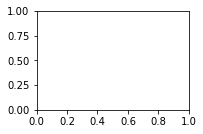

In [24]:
acc=conv_3d_model_history.history["acc"]
val_acc=conv_3d_model_history.history["val_acc"]
loss=conv_3d_model_history.history["loss"]
val_loss=conv_3d_model_history.history["val_loss"]


epochs=np.arange(1,13)

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

In [25]:
# modelu_6=load_model('stretch_model_conv_3d_new3.h5')
modelu_6=load_model('stretch_model_conv_3d_new4.h5')

modelu_6.evaluate(test_dataset_new,test_labels)

4/4 [==============================] - 53s 13s/step - loss: 0.6010 - acc: 0.6583


[0.600986123085022, 0.6583333611488342]

In [26]:
test_preds=modelu_6.predict(test_dataset_new)

In [27]:
test_preds

array([[0.8294385 ],
       [0.68929076],
       [0.65176874],
       [0.49636284],
       [0.71569026],
       [0.781121  ],
       [0.6137736 ],
       [0.6053577 ],
       [0.78154063],
       [0.8229957 ],
       [0.6112093 ],
       [0.4915831 ],
       [0.83678925],
       [0.6559876 ],
       [0.6453689 ],
       [0.81132597],
       [0.5613221 ],
       [0.7124746 ],
       [0.7472575 ],
       [0.49624452],
       [0.6609893 ],
       [0.7582837 ],
       [0.72265756],
       [0.8250111 ],
       [0.70356077],
       [0.49432904],
       [0.8276923 ],
       [0.5832994 ],
       [0.46006033],
       [0.62115353],
       [0.758623  ],
       [0.6230152 ],
       [0.61830163],
       [0.42157656],
       [0.49015692],
       [0.7555824 ],
       [0.68423647],
       [0.6324316 ],
       [0.64888775],
       [0.6555878 ],
       [0.6819281 ],
       [0.7754133 ],
       [0.71946204],
       [0.49146688],
       [0.50417167],
       [0.7196727 ],
       [0.5999206 ],
       [0.550

In [29]:
test_dataset_new[0]

array([[[0.00392157, 0.        , 0.04313725, ..., 0.6627451 ,
         0.65098039, 0.64313725],
        [0.00392157, 0.        , 0.04313725, ..., 0.69803922,
         0.68627451, 0.6745098 ],
        [0.00392157, 0.        , 0.04313725, ..., 0.70980392,
         0.69411765, 0.68627451],
        ...,
        [0.00392157, 0.        , 0.03921569, ..., 0.5372549 ,
         0.54901961, 0.54901961],
        [0.00392157, 0.        , 0.03137255, ..., 0.58039216,
         0.56470588, 0.54117647],
        [0.00392157, 0.        , 0.01568627, ..., 0.22352941,
         0.22352941, 0.2       ]],

       [[0.00392157, 0.        , 0.04313725, ..., 0.6627451 ,
         0.65098039, 0.64313725],
        [0.00392157, 0.        , 0.04313725, ..., 0.69803922,
         0.68627451, 0.6745098 ],
        [0.00392157, 0.        , 0.04313725, ..., 0.70980392,
         0.69411765, 0.68627451],
        ...,
        [0.00392157, 0.        , 0.03921569, ..., 0.54901961,
         0.57254902, 0.58039216],
        [0.0

In [1]:
from PyQt5 import QtGui, QtWidgets, uic
from PyQt5.QtWidgets import QWidget, QApplication, QLabel, QVBoxLayout
from PyQt5.QtGui import QPixmap
from PyQt5.QtWidgets import *
import sys
import cv2
from PyQt5.QtCore import pyqtSignal, pyqtSlot, Qt, QThread
import numpy as np


class VideoThread(QThread):
    change_pixmap_signal = pyqtSignal(np.ndarray)    
   
    def __init__(self):
        super().__init__()
        self._run_flag = True

    def run(self):
        # capture from web cam
        cap = cv2.VideoCapture('C:\\Personal\\dataset\\test.m4v')
          # get the versions of cv2 and convert them to a python list [major_version, minor_version, subminor_version]
        versions = str(cv2.__version__).split('.')
       # check if the major version integer value is less or greater than 3
        if int(versions[0]) < 3:
           # if less fps will be equal to
           fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
        else:
           # if greater fps will be
           fps = cap.get(cv2.CAP_PROP_FPS)
        print(fps)
        while self._run_flag:
            success, img = cap.read()
            if success:
                self.change_pixmap_signal.emit(img)
                # On the waitKey() pass the integer value of 1000/fps as shown bellow
            if cv2.waitKey(int(1000/fps)) & 0xFF == ord('q'):
                 break
           
        # shut down capture system
        cap.release()

    def stop(self):
        """Sets run flag to False and waits for thread to finish"""
        self._run_flag = False

        #self.wait()



class Ui(QtWidgets.QMainWindow):
    def __init__(self):
        super(Ui, self).__init__()
        uic.loadUi('C:\\personal\\dataset\\1.ui', self)
        self.button = self.findChild(QtWidgets.QPushButton, 'pushButton')
        self.button.setText("PLAY")
        self.button.clicked.connect(self.activate_thread)
       
        self.show()
    def clicked(self, qmodelindex):
        item = self.listwidget.currentItem()
        print(item.text())
    

    def closeEvent(self):
        self.thread.stop()
        self.__init__()
        self.button.clicked.connect(self.activate_thread)
        #event.accept()

    def activate_thread(self):
        # create the video capture thread
        self.thread = VideoThread()
        # connect its signal to the update_image slot
        self.thread.change_pixmap_signal.connect(self.update_image)
        # start the thread
        self.thread.start()

        self.pushButton_2.clicked.connect(self.thread.stop)

    @pyqtSlot(np.ndarray)
    def update_image(self, cv_img):
        """Updates the image_label with a new opencv image"""
        qt_img = self.convert_cv_qt(cv_img)
        self.label.setPixmap(qt_img)

    def convert_cv_qt(self, cv_img):
        """Convert from an opencv image to QPixmap"""
        rgb_image = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
        h, w, ch = rgb_image.shape
        bytes_per_line = ch * w
        convert_to_Qt_format = QtGui.QImage(rgb_image.data, w, h, bytes_per_line, QtGui.QImage.Format_RGB888)
        p = convert_to_Qt_format.scaled(self.disply_width, self.display_height, Qt.KeepAspectRatio)
        return QPixmap.fromImage(p)

if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv)
    window = Ui()
    app.exec_()

NameError: name 'uic' is not defined